# Map of locations where run SNOWPACK
### First import python modules

In [1]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.cm as cm
import matplotlib.colors as colors
import shapefile as shp
from palettable.colorbrewer.sequential import *
from palettable.cmocean.sequential import *
import geopandas as gpd

### Function to get lat/lon of simulation

In [2]:
"""
Function that returns latitude and longitude of SNOWPACK simulation

    Arguments:
        smet_path - path to.smet file, this is where lat/lon are. 
            Note that both forcing and output .smet files contain this information. 
        
    Retruns: 
        lat - latitude of simulation.
        lon - longitude of simulation. 
"""
def get_lat_lon(smet_path):
    # Read only the fist n lines
    n_lines = 100
    
    # Read the first n lines, and return as an array of strings
    with open(smet_path) as myfile:
        lines = [next(myfile) for x in range(n_lines)]
    
    # Search the lines for lat information
    for j in range(0, n_lines):
        if lines[j].startswith("latitude"):
            lat = lines[j].split()[-1]
            break

    # Search the lines for lon information
    for j in range(0, n_lines):
        if lines[j].startswith("longitude"):
            lon = lines[j].split()[-1]
            break
    
    # Return lat/lon
    return lat, lon

### Function to get lat, lon at multiple sites

In [3]:
"""
Function that returns latitude and longitude of multiple SNOWPACK simulations

    Arguments:
        smet_paths - path to .smet files, this is where lat/lon are. 
            Note that both forcing and output .smet files contain this information. 
        
    Retruns: 
        lats - latitudes of simulations.
        lons - longitudes of simulations. 
"""
def get_multiple_lat_lon(smet_paths):
    n_files = len(smet_paths)
    lats = np.empty(n_files)
    lons = np.empty(n_files)
    
    for k in range(0, n_files):
        lats[k], lons[k] = get_lat_lon(smet_paths[k])

    return lats, lons

### Load latitude/longitude coordinates of model simulations

In [4]:
# IMAU AWS 
IMAU_smet_paths = glob.glob("/pl/active/nasa_smb/simulations/up_to_date_simulations/not_bias_corrected_radiation/AWS_*/output/AWS_*smet")
IMAU_lats, IMAU_lons = get_multiple_lat_lon(IMAU_smet_paths)
    
# Ice cores
ice_core_smet_paths = glob.glob("/projects/erke2265/1D_Snowpack/Forcing/ice_core_smet/*.smet")
ice_core_lats, ice_core_lons = get_multiple_lat_lon(ice_core_smet_paths)

# Profiles
profiles_smet_paths = glob.glob("/projects/erke2265/1D_Snowpack/Simulations/density_profile/density_profile_*/output/*.smet")
profiles_lats, profiles_lons = get_multiple_lat_lon(profiles_smet_paths)

### Load MERRA-2 precipitation over the Antarctic ice sheet

In [5]:
M2_PE_path = "/pl/active/nasa_smb/Data/MERRA-2-P-E-yearly-1980-2017.nc"
M2_PE = xr.open_dataset(M2_PE_path)
M2_PE = M2_PE['precip'] - M2_PE['evap']
M2_PE = M2_PE.sum(dim = 'time') / len(M2_PE['time'])
M2_PE = M2_PE.where(M2_PE['lat'] <= -50, drop = True)

## Mask MERRA-2 to AIS and ice shelves

In [6]:
# Make filter
mask_path = "/pl/active/nasa_smb/Data/AIS_basins_Zwally_MERRA2grid.nc"
mask = xr.open_dataset(mask_path)
mask = mask['Zwallybasins'] / mask['Zwallybasins']

# Apply filter
M2_PE = M2_PE * mask

### Plot sites on 1 map

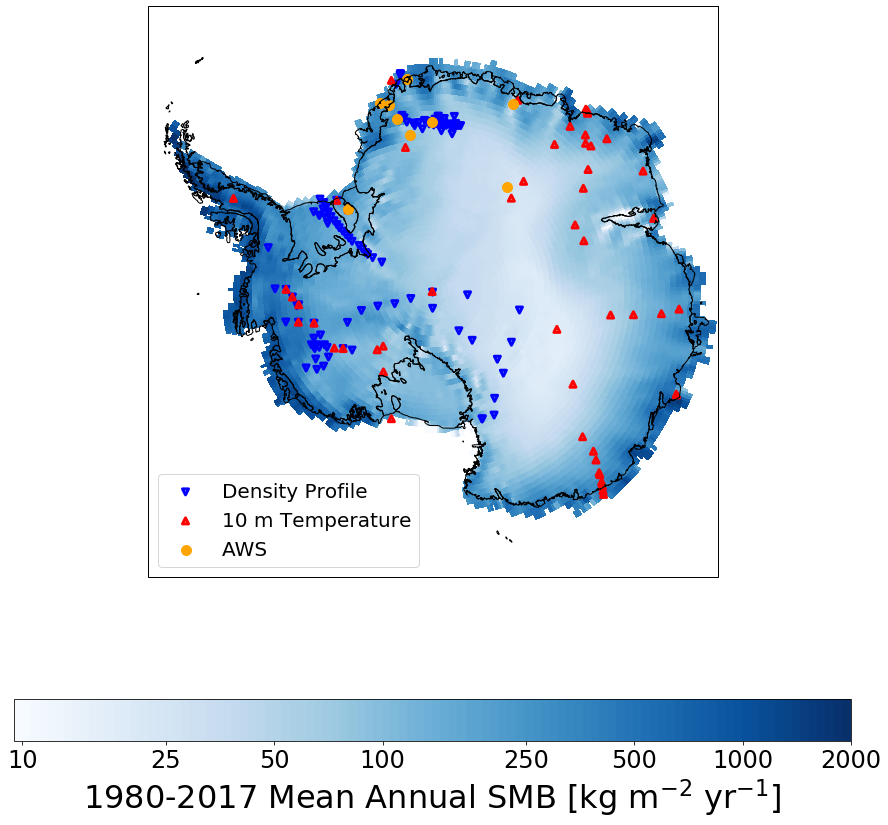

In [8]:
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(15, 15))

# Plot SMB
colormap = Blues_9.mpl_colormap
boundaries = np.logspace(np.log10(10), np.log10(2000), 100)
boundaries = np.insert(boundaries, 0, 0)
norm = colors.BoundaryNorm(boundaries, colormap.N, clip=True)
M2_PE['lon'] = np.linspace(-180, 180, len(M2_PE['lon']))
mesh = plt.pcolormesh(M2_PE['lon'], M2_PE['lat'], M2_PE, cmap = colormap, 
                    norm = norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, orientation = 'horizontal', ticks = [10, 25, 50, 100, 250, 500, 1000, 2000])
cbar.set_label("1980-2017 Mean Annual SMB [kg m$^{-2}$ yr$^{-1}$]", size = 32)
cbar.ax.tick_params(labelsize=24)

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot Simulation Locations
profiles = axs.scatter(profiles_lons, profiles_lats, marker = "v", facecolors = 'none', 
                          edgecolors = 'b', linewidth = 3, transform=ccrs.Geodetic(), 
                          label = "Density Profile")
cores = axs.scatter(ice_core_lons, ice_core_lats, marker = "^", facecolors = 'none', 
                          edgecolors = 'r', linewidth = 3, transform=ccrs.Geodetic(), 
                          label = "10 m Temperature")
AWS = axs.scatter(IMAU_lons, IMAU_lats, s = 100, color = 'orange',
                      transform=ccrs.Geodetic(), label = "AWS")
plt.legend(prop={'size': 20})

plt.savefig('Figures/SNOWPACK_MAP.pdf', format='pdf', dpi=100)